# **Specific Test IV. Diffusion Models**

### **Introduction**

Gravitational Lensing occurs when an extremely massive celestial body causes curvature in spacetime, visibly bending the light around it. *Gravitational Lens* is the term used to refer to these bodies. Basically, **the light from sources like other galaxies and stars are redirected around the gravitational lens, making the light look “bent”**. A famous example of this can be seen in the theorized black hole images

This was *first theorised by Einstein* in his General Theory of Relativity, where he described how space around mass concentrations get distorted.

### **Task at hand**: Train a diffusion model to generate lensing images

**Visualizing the given data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = '/kaggle/input/diffusion-model/Samples/'

(-0.5, 149.5, 149.5, -0.5)

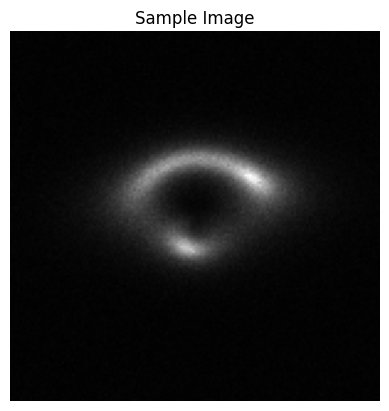

In [4]:
sample = np.squeeze(np.load(path+'sample4564.npy'))

plt.imshow(sample, cmap="gray")
plt.title("Sample Image")
plt.axis("off")

In [5]:
np.max(sample), np.min(sample)

(1.0, 0.0)

### **Extracting training data into a pytorch dataset**
The images are initially in the form of numpy arrays, hence they must be converted to tensors before being converted into a dataset. 

They have been resized to 128x128 as well, in order to accommodate the limitations in the available computation

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import os, torch

In [ ]:
class GetDataset(Dataset):
    def __init__(self, folder_path, img_size=128):  # converting images to 128x128 due to limitations on compute
        '''
            Input:
                folder_path - location of the training images 
                img_size - size to which the image must be converted to
        '''
        self.img_size = img_size
        self.folder_path = folder_path
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
        
    def __getitem__(self, index):
        '''
            Input:
                index - index of the image in the files list

            Output:
                img - resized image tensor
        '''

        file = os.path.join(self.folder_path, self.files[index])
        
        # loading an npy image and converting it to a tensor
        img = np.load(file).astype(np.float32)
        img = torch.from_numpy(img)

        # if self.transform:
        #     img = Image.fromarray(img.numpy().astype(np.uint8).transpose(1, 2, 0))
        #     img = self.transform(img)
        
        img = TF.resize(img, (self.img_size, self.img_size), antialias=True)
        return img
    
    def __len__(self):  # number of images available in the dataset
        return len(self.files)

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to 128x128
#     transforms.ToTensor(),
# ])

In [7]:
dataset = GetDataset(path)
dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

In [8]:
dataloader

In [ ]:
# to check the size of each tensor in the dataset
for batch in dataloader:
    print(batch.shape)
    break

torch.Size([24, 1, 128, 128])


## **Understanding the Model**

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### **Denoising Diffusion Probabilistic Models**
This is an alternative approach to GANs (Generative Adversial Networks)

This is a class of generative models that work by iteratively adding noise to an input signal and then learning to denoise from the noisy signal to generate new samples

`reference for codebase: https://github.com/lucidrains/denoising-diffusion-pytorch`

In [ ]:
!pip install denoising_diffusion_pytorch

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torchvision.utils as utils 
import torch.optim as optim

**U-Net Backbone**
- U-Net architecture is used as the backbone for this way of defining a diffusion model.
- The base features are of dimension 64x64
- Here, the model's channels have been set to 1 as the input data are grayscale images

**Gaussian Diffusion Framework**
- This is the framework that adds noise to the training images that can be used to generate new samples in the reverse diffusion process.
- The noising process happens over `timesteps` number of steps and then denoising happens during sampling using the **U-Net model**

In [ ]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1,
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,   # images should be of size 128x128
    timesteps = 1000    # number of steps
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [ ]:
diffusion = diffusion.to(device)    # setting device to gpu (cuda)

**Visualization**

A function to visualize the images generated by the model at any given stage 

In [ ]:
def visualize_samples(model, epoch, bts=4):
    model.eval()
    with torch.no_grad():
        samples = diffusion.sample(batch_size=bts).cpu()

    # (C, H, W) to (H, W, C)
    grid_img = utils.make_grid(samples, nrow=2, normalize=True)
    grid_img = grid_img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.axis("off")
    plt.title(f"Generated at Epoch {epoch}")
    plt.show()

In [ ]:
epochs = 75
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
grad_clip = 1.0

100%|██████████| 417/417 [06:39<00:00,  1.04it/s]


Epoch [1/75], Loss: 0.0785


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [2/75], Loss: 0.0185


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [3/75], Loss: 0.0123


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [4/75], Loss: 0.0098


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [5/75], Loss: 0.0080


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [6/75], Loss: 0.0071


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [7/75], Loss: 0.0064


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [8/75], Loss: 0.0061


100%|██████████| 417/417 [05:22<00:00,  1.30it/s]


Epoch [9/75], Loss: 0.0053


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]

Epoch [10/75], Loss: 0.0049


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

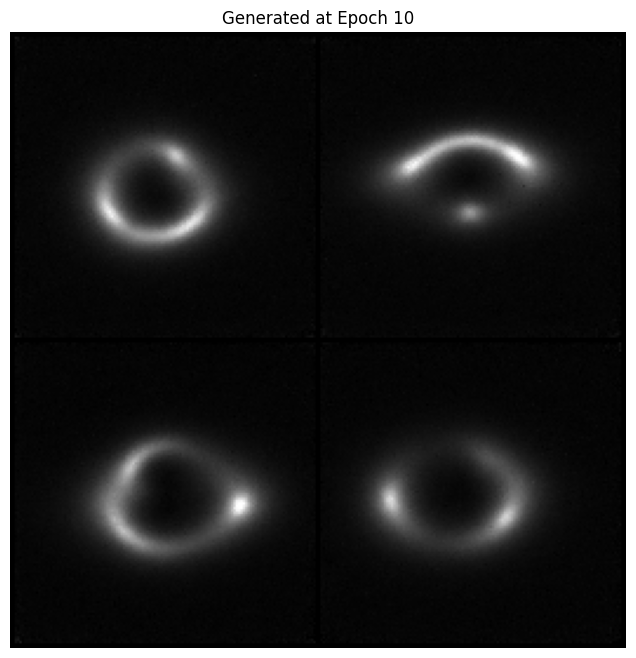

100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [11/75], Loss: 0.0048


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [12/75], Loss: 0.0050


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [13/75], Loss: 0.0045


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [14/75], Loss: 0.0042


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [15/75], Loss: 0.0041


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [16/75], Loss: 0.0043


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [17/75], Loss: 0.0039


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [18/75], Loss: 0.0038


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [19/75], Loss: 0.0039


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]

Epoch [20/75], Loss: 0.0036


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

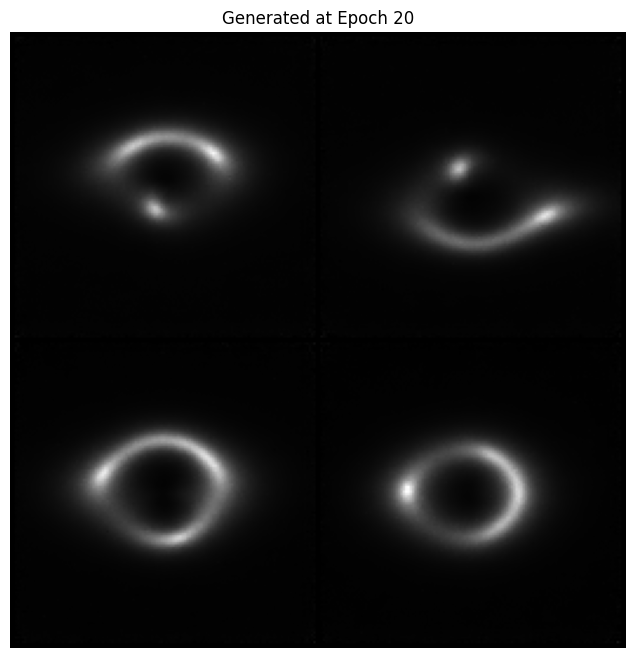

100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [21/75], Loss: 0.0034


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [22/75], Loss: 0.0034


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [23/75], Loss: 0.0033


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [24/75], Loss: 0.0033


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [25/75], Loss: 0.0033


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [26/75], Loss: 0.0029


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [27/75], Loss: 0.0032


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [28/75], Loss: 0.0031


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [29/75], Loss: 0.0030


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]

Epoch [30/75], Loss: 0.0030


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

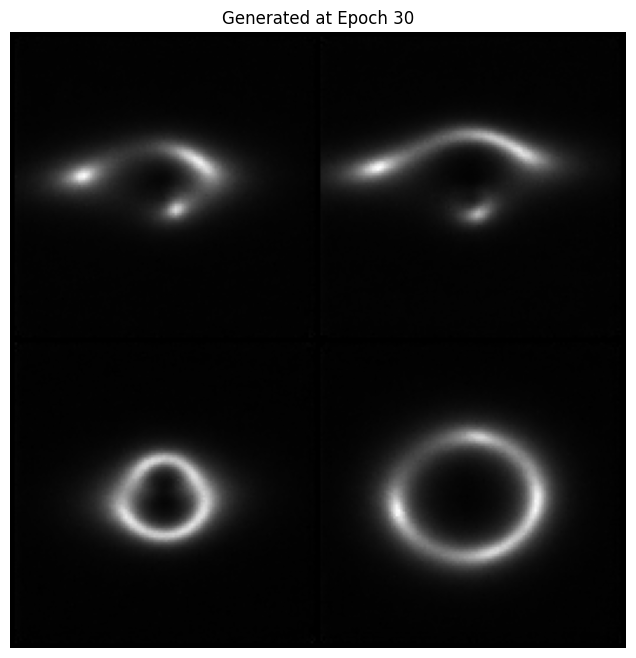

100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [31/75], Loss: 0.0028


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [32/75], Loss: 0.0030


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [33/75], Loss: 0.0029


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [34/75], Loss: 0.0029


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [35/75], Loss: 0.0028


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [36/75], Loss: 0.0028


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [37/75], Loss: 0.0028


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [38/75], Loss: 0.0029


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [39/75], Loss: 0.0027


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]

Epoch [40/75], Loss: 0.0026


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

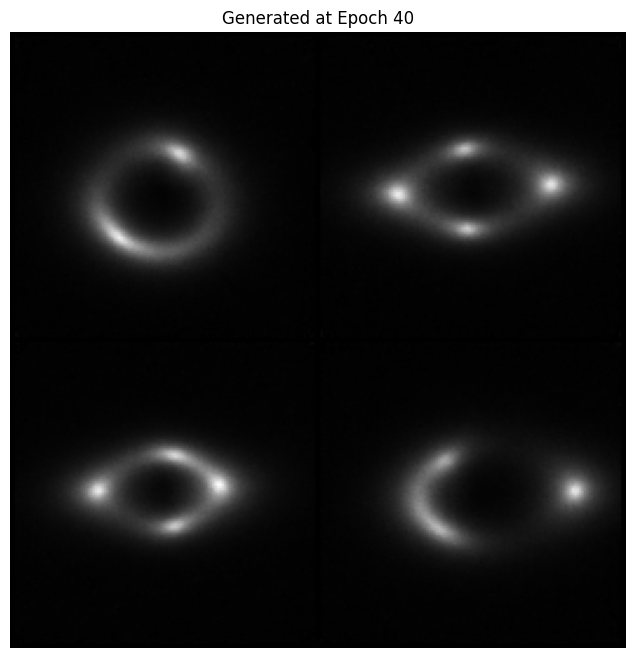

100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [41/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [42/75], Loss: 0.0029


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [43/75], Loss: 0.0026


100%|██████████| 417/417 [05:24<00:00,  1.29it/s]


Epoch [44/75], Loss: 0.0027


100%|██████████| 417/417 [05:24<00:00,  1.29it/s]


Epoch [45/75], Loss: 0.0027


100%|██████████| 417/417 [05:23<00:00,  1.29it/s]


Epoch [46/75], Loss: 0.0027


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [47/75], Loss: 0.0028


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [48/75], Loss: 0.0028


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [49/75], Loss: 0.0025


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]

Epoch [50/75], Loss: 0.0025


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

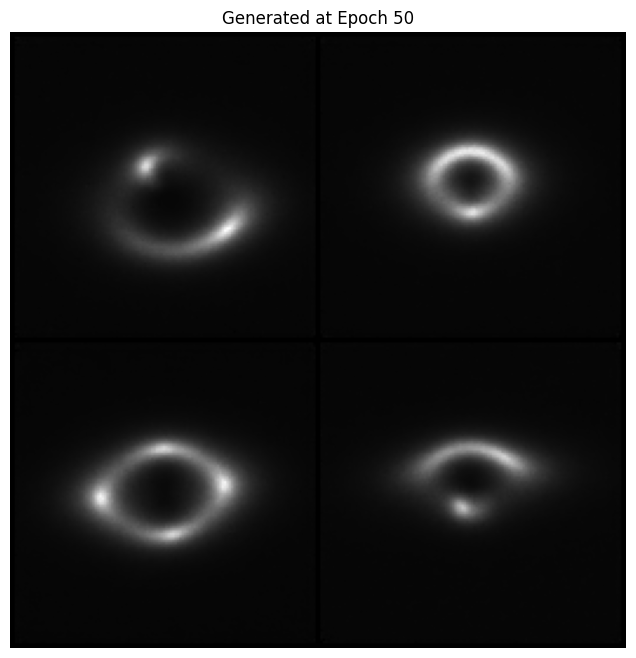

100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [51/75], Loss: 0.0025


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [52/75], Loss: 0.0025


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [53/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [54/75], Loss: 0.0026


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [55/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [56/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [57/75], Loss: 0.0023


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [58/75], Loss: 0.0025


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [59/75], Loss: 0.0025


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]

Epoch [60/75], Loss: 0.0024


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

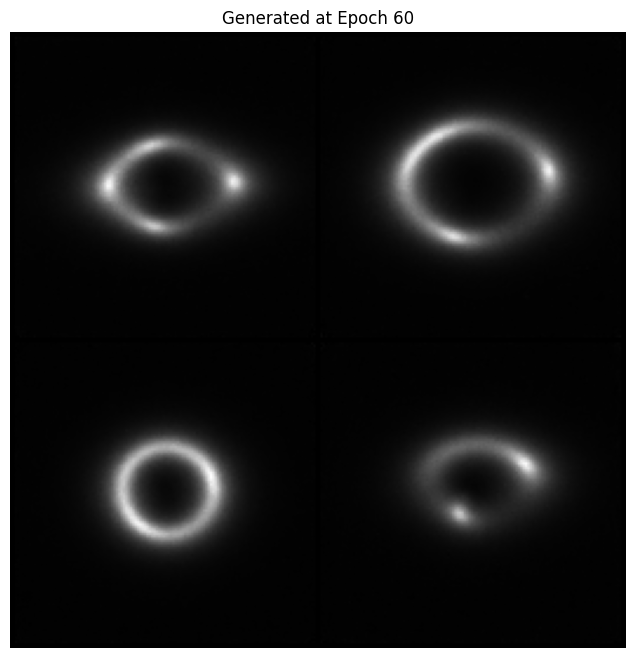

100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [61/75], Loss: 0.0022


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [62/75], Loss: 0.0022


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [63/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [64/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [65/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [66/75], Loss: 0.0023


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [67/75], Loss: 0.0025


100%|██████████| 417/417 [05:21<00:00,  1.30it/s]


Epoch [68/75], Loss: 0.0023


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [69/75], Loss: 0.0026


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]

Epoch [70/75], Loss: 0.0023


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

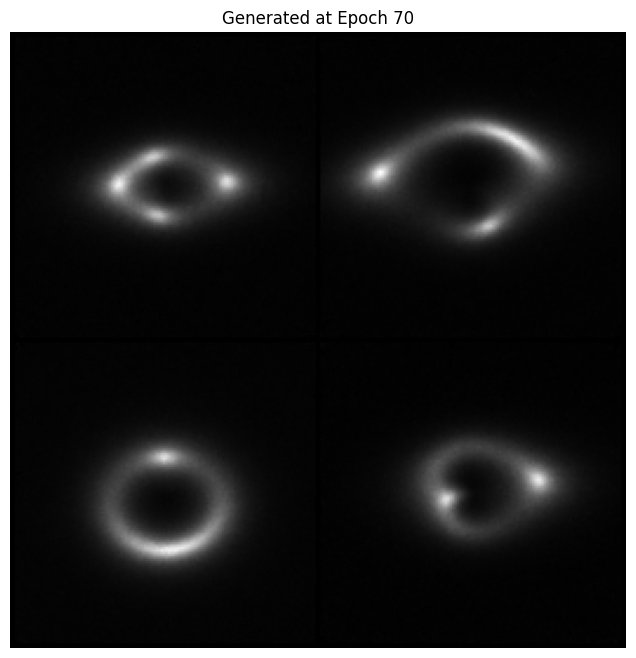

100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [71/75], Loss: 0.0022


100%|██████████| 417/417 [05:23<00:00,  1.29it/s]


Epoch [72/75], Loss: 0.0024


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [73/75], Loss: 0.0023


100%|██████████| 417/417 [05:22<00:00,  1.29it/s]


Epoch [74/75], Loss: 0.0023


100%|██████████| 417/417 [05:23<00:00,  1.29it/s]


Epoch [75/75], Loss: 0.0023


In [ ]:
from tqdm import tqdm

# the training process
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()  # reset gradients
        loss = diffusion(batch) # forward
        loss.backward() # backprop

        # apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()  # update weights
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)  # track average loss of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    # visualize results after every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_samples(model, epoch + 1)

**saving the model for future testing**

In [20]:
save_path = "/kaggle/working/diffusion_model.pth"

model.eval()
torch.save(model.state_dict(), save_path)
print(f"model saved!")

model saved!


playing around with the trained model to generate some more images

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

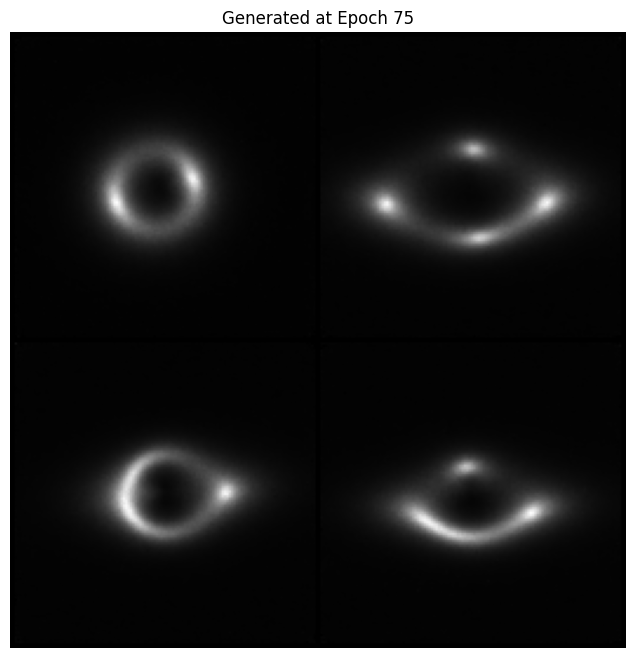

In [23]:
visualize_samples(epochs, 4)

### **Testing the saved model**

*The trained model weights :*

In [39]:
mod = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1,
    flash_attn = True
)

mod.load_state_dict(torch.load('/kaggle/working/diffusion_model.pth', weights_only=True))
mod.eval()

Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (res_conv): Identity()
      )
      (2): Line